### Graph Neural Network

The following code as well as the associated functions are developed by Vu et al. (20424). The original code can be found here: https://github.com/duclong1009/Unsupervised-Air-Quality-Estimation 

Adaptions:
- exclusion of RNN (adaption of Attention_STDGI)
- new Preprocessing
- development of decoder- and encoder_tune.py

Vu, V., Nguyen, D., Nguyen, T., Nguyen, Q., P.L., N., & Huynh, T. (2024). Self-supervised air quality estimation with graph neural network assistance and attention enhancement. Neural Computing and Applications.

In [1]:
from torch.utils.data import DataLoader
import torch.nn as nn
from utilities.functions.constructor import Preprocessing, AQDataSet # load own external functions
from utilities.functions.encoder import Attention_STDGI, train_atten_stdgi
from utilities.functions.utilities import EarlyStopping
import logging, os, torch


# 1. define device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. construct data array
main = Preprocessing(path_data= os.path.abspath('data/df_2023_imputed.csv'),
                     path_coor= os.path.abspath('data/monitoring_station/monitoring_station.shp'),
                     path_impute_index= os.path.abspath('data/index_imputed_no2_values.pkl'))
                  

stations = main.stations
distance_matrix = main.get_distance_matrix()
corr, norm_loc, norm_temp, norm_imputed, scaler = main.construct_data()


# 3. train 13 graph embeddings
    # 3.1 adjustable hyperparameter

sequence_length = 12
batch_size = 24 
lr_encoder = 0.001790
lr_decoder = 0.000612
l2_coef_e = 0.007949
l2_coef_d = 0.000203
momentum_d = 0.52711

# initiate leave one station out 
bce_loss = nn.BCELoss()
train_station = [2, 4, 5, 6, 8, 9, 11, 12, 14, 15] + [0, 3, 13]



    # 1. construct graph neural network for current training stations
train_dataset = AQDataSet(
    data_df= norm_loc,  
    climate_df= norm_temp,
    distance_matrix= distance_matrix,
    list_train_station= train_station,
    input_dim= sequence_length,
    #absolute_distance = True,
    corr=corr        
)

train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers=0)

# 2. initialize network architecture
stdgi = Attention_STDGI(
    in_ft= norm_loc.shape[2],
    out_ft= 60,
    en_hid1= 48, # adjustable
    en_hid2= 64, # adjustable
    dis_hid= 6,
    device= device,
    stdgi_noise_min= 0.4, # adjustable
    stdgi_noise_max= 0.7, # adjustable
    
).to(device)

stdgi_optimizer_e = torch.optim.Adam(stdgi.encoder.parameters(), lr= lr_encoder, weight_decay=l2_coef_e)
stdgi_optimizer_d = torch.optim.RMSprop(stdgi.disc.parameters(), momentum= momentum_d, lr= lr_decoder, weight_decay=l2_coef_d)

# 3. run model 
early_stopping_stdgi = EarlyStopping(patience=10, verbose=True, delta=0.003, path= os.path.abspath(f'model_parameter/encoder/model_weights_encoder.pt'))


logging.info(f"Training stdgi || attention decoder || epochs {30} || lr {lr_encoder}")

train_stdgi_loss = []
for i in range(30):
    if not early_stopping_stdgi.early_stop:
        loss = train_atten_stdgi(
            stdgi,
            train_dataloader,
            stdgi_optimizer_e,
            stdgi_optimizer_d,
            bce_loss,
            device,
            n_steps=2, # adjustable
        )
        early_stopping_stdgi(loss, stdgi)
                
        logging.info("Epochs/Loss: {}/ {}".format(i, loss))
        print(loss)

c:\Users\richa\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Validation loss decreased (inf --> 0.316153).
0.3161527669477847
Validation loss decreased (0.316153 --> 0.154980).
0.15497973144294755
Validation loss decreased (0.154980 --> 0.086079).
0.08607899208342837
Validation loss decreased (0.086079 --> 0.047193).
0.047193176819071654
Validation loss decreased (0.047193 --> 0.035390).
0.03539028841431343
Validation loss decreased (0.035390 --> 0.022319).
0.022318667257880613
Validation loss decreased (0.022319 --> 0.017661).
0.017661124268817083
Validation loss decreased (0.017661 --> 0.014178).
0.014177964759930488
0.014792855217632267
EarlyStopping counter: 2 out of 10
0.013255573279644934
0.011778184903349968
EarlyStopping counter: 4 out of 10
0.01391719689333601
Validation loss decreased (0.014178 --> 0.010006).
0.010005686180515876
0.010331966022344968
EarlyStopping counter: 2 out of 10
0.00810308348858774
Validation loss decreased (0.010006 --> 0.006401).
0.006401354083772599
0.005808145502880741
EarlyStopping counter: 2 out of 10
0.004

In [ ]:
from utilities.functions.constructor import Preprocessing, AQDataSet # load own external functions
from utilities.functions.encoder import Attention_STDGI
from utilities.functions.decoder import Local_Global_Decoder,train_atten_decoder_fn
from torch.utils.data import DataLoader
import torch, os
import torch.nn as nn



mse_loss = nn.MSELoss()

# 1. define device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. construct data array
main = Preprocessing(path_data= os.path.abspath('data/df_2023_imputed.csv'),
                     path_coor= os.path.abspath('data/monitoring_station/monitoring_station.shp'),
                     path_impute_index= os.path.abspath('data/index_imputed_no2_values.pkl'))

stations = main.stations
distance_matrix = main.get_distance_matrix()
corr, norm_loc, norm_temp, norm_imputed, scaler = main.construct_data()


sequence_length = 12
mse_loss = nn.MSELoss()
train_station = [2, 4, 5, 6, 8, 9, 11, 12, 14, 15] + [0, 3, 13]


# adjustable parameter decoder architecture:
cnn_hid_dim = 48
fc_hidden_dim = 80
activation = 'relu'
n_layer= 3  
l2_coef = 5.738497802114681e-05
lr_decoder = 0.0011936596613317412 
momentum = 0.9888714024473448
batch_size = 24

# initialize decoder
decoder = Local_Global_Decoder(norm_loc.shape[2] + 60,
                        1,
                        n_layers_rnn= 1,
                        cnn_hid_dim= cnn_hid_dim, # adjustable
                        fc_hid_dim= fc_hidden_dim, # adjustable
                        n_features= norm_temp.shape[2],  
                        num_input_stat= len(train_station),
                        n_layer= n_layer,
                        activation= activation
                        ).to(device)


optimizer_decoder = torch.optim.SGD(decoder.parameters(), lr = lr_decoder, weight_decay = l2_coef, momentum = momentum)

total_loss = 0
mae_loss = 0



#initialize new model 
stdgi = Attention_STDGI(
   in_ft=norm_loc.shape[2], out_ft=60, en_hid1=48, en_hid2=64, dis_hid=6,
   stdgi_noise_min=0.4, stdgi_noise_max=0.7, device= device)


#load the state dictionary of embedding
checkpoint = torch.load('model_parameter/encoder/model_weights_encoder.pt', map_location=torch.device(device))
stdgi.load_state_dict(checkpoint['model_dict'])
stdgi.to(device)

    

# specify training data
train_dataset = AQDataSet(
    data_df= norm_loc,  
    climate_df= norm_temp,
    distance_matrix= distance_matrix,
    list_train_station= train_station,
    input_dim= sequence_length,
    corr=corr        
)


train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers=0)



for i in range(55):
    
    train_loss = train_atten_decoder_fn(
        stdgi,
        decoder,
        train_dataloader,
        mse_loss,
        optimizer_decoder,
        device,
    )
    checkpoints = {"model_dict": decoder.state_dict()}
    torch.save(checkpoints, 'model_parameter/decoder/model_weights_decoder.pt')
            
    print(f"{i}: {train_loss}")       


### Model and Error Analysis:

1. initialize embedding + load model parameters for embedding
2. initialize dense attention model + load model parameters

In [2]:
# INITIALIZE DATA + ENCODER AND DECODER MODEL + LOAD TRAINED MODELS 
# load own external functions
from utilities.functions.constructor import Preprocessing, AQDataSet 
from utilities.functions.decoder import Local_Global_Decoder, test_atten_decoder_fn
from utilities.functions.encoder import Attention_STDGI
from sklearn.preprocessing import MinMaxScaler
# evaluation function
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import os, torch
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 0. define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. construct data (in alignment with trained parameters) - scaling function & distance method
main = Preprocessing(path_data= os.path.abspath('data/df_2023_imputed.csv'),
                     path_coor= os.path.abspath('data/monitoring_station/monitoring_station.shp'),
                     path_impute_index= os.path.abspath('data/index_imputed_no2_values.pkl'))
                    



stations = main.stations
distance_matrix = main.get_distance_matrix()
corr, norm_loc, norm_temp, norm_imputed, scaler = main.construct_data()




# define test stations
test_station = [1, 10, 7]
train_station = [2, 4, 5, 6, 8, 9, 11, 12, 14, 15] + [0, 3, 13]


# 2. initialize spatio-temporal deep graph infomax (stdgi) for embedding learning + hyperparameters learned by hyperopt
stdgi = Attention_STDGI(
    in_ft=norm_loc.shape[2], out_ft=60, en_hid1=48, en_hid2=64, dis_hid=6,
    stdgi_noise_min=0.4, stdgi_noise_max=0.7, device= device)


# 2.1 load the state dictionary of embedding
checkpoint = torch.load('model_parameter/encoder/model_weights_encoder.pt', map_location= device)
stdgi.load_state_dict(checkpoint['model_dict'])
stdgi.to(device)


# adjustable parameter decoder architecture:
cnn_hid_dim = 48
fc_hidden_dim = 80
activation = 'relu'
n_layer= 3  
l2_coef = 5.738497802114681e-05
lr_decoder = 0.0011936596613317412 
momentum = 0.9888714024473448
batch_size = 24


# initialize decoder
decoder = Local_Global_Decoder(norm_loc.shape[2] + 60,
                        1,
                        n_layers_rnn= 1,
                        cnn_hid_dim= cnn_hid_dim, # adjustable
                        fc_hid_dim= fc_hidden_dim, # adjustable
                        n_features= norm_temp.shape[2],  
                        num_input_stat= len(train_station),
                        n_layer= n_layer,
                        activation= activation
                        ).to(device)

# load the state dictionary of embedding
checkpoint = torch.load('model_parameter/decoder/model_weights_decoder.pt', map_location= device)
decoder.load_state_dict(checkpoint['model_dict'])
decoder.to(device)

print()

prop_intercept_200
Test Accuracy: 4.322857541642121
Test Accuracy: 2.4419177446969647
Test Accuracy: 6.3265762914338834
   STATION       MAE        MSE      MAPE      MDAPE      RMSE        R2  \
0      1.0  4.322858  33.615848  0.396904  28.658703  5.797918  0.734192   
1     10.0  2.441918  15.917157  0.350393  29.911430  3.989631  0.523746   
2      7.0  6.326576  73.749036  0.424585  30.426432  8.587726  0.576865   
3      8.5  4.384247  44.833096  0.387489  30.168931  6.288679  0.550305   

       CORR  
0  0.876371  
1  0.800587  
2  0.798412  
3  0.799500  


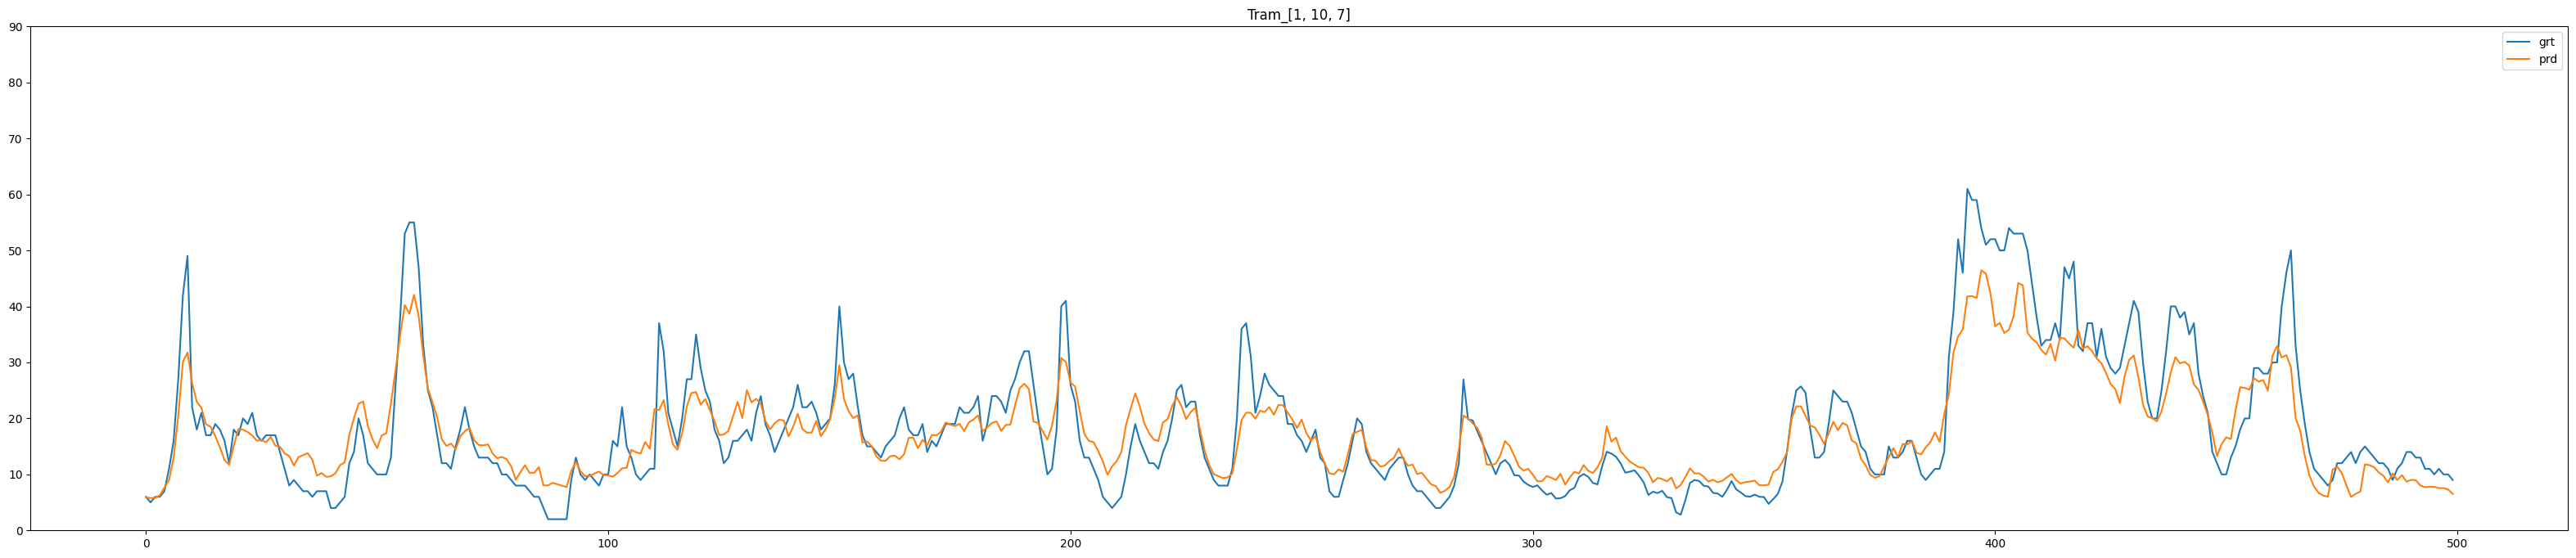

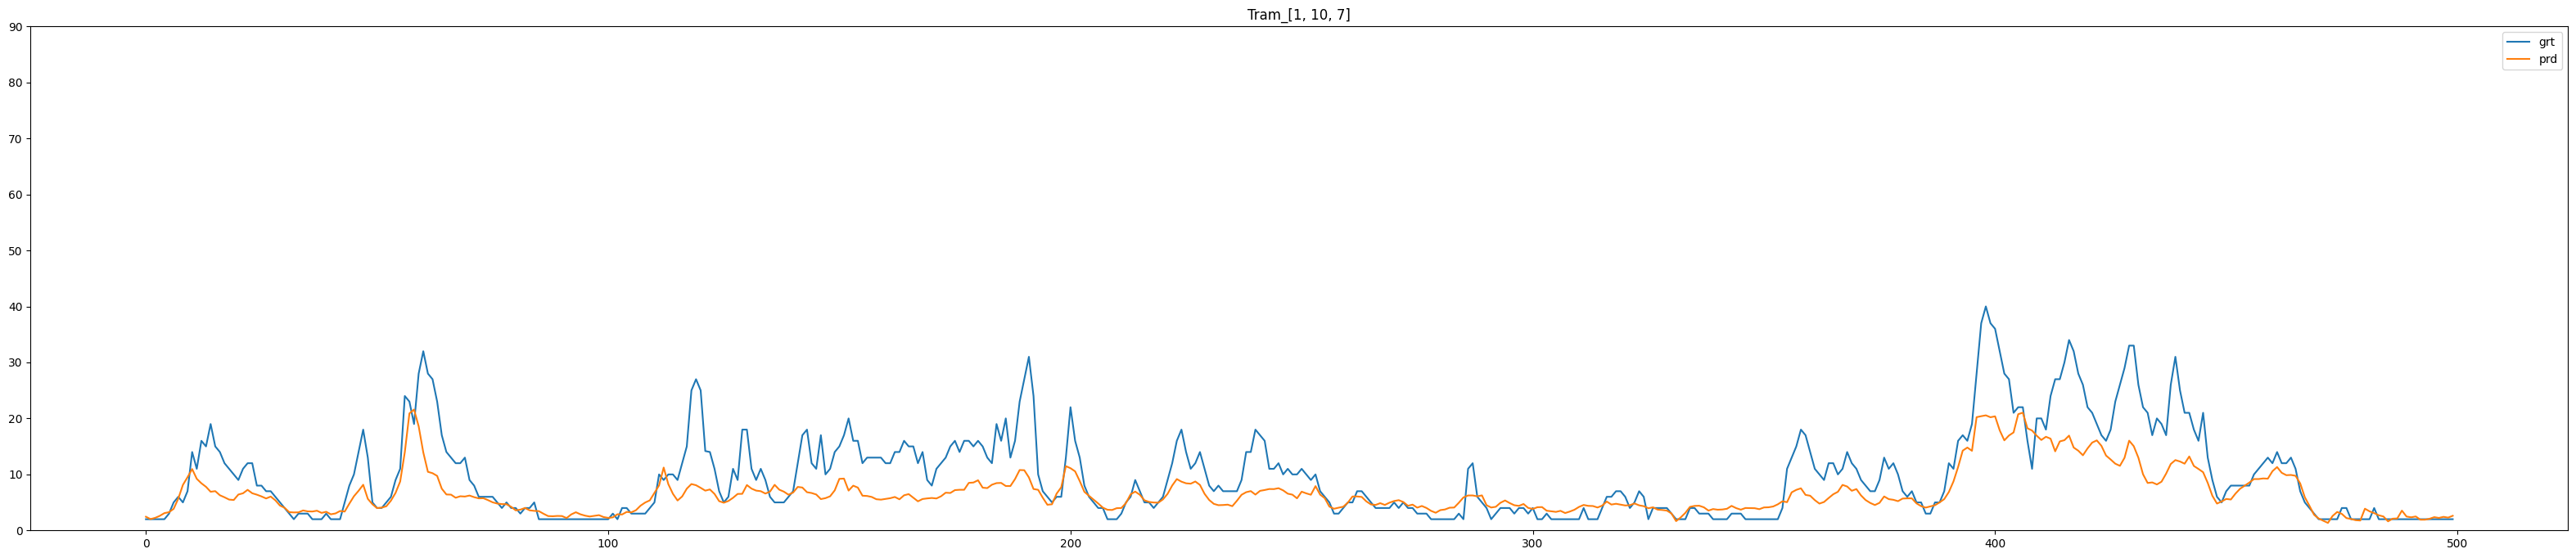

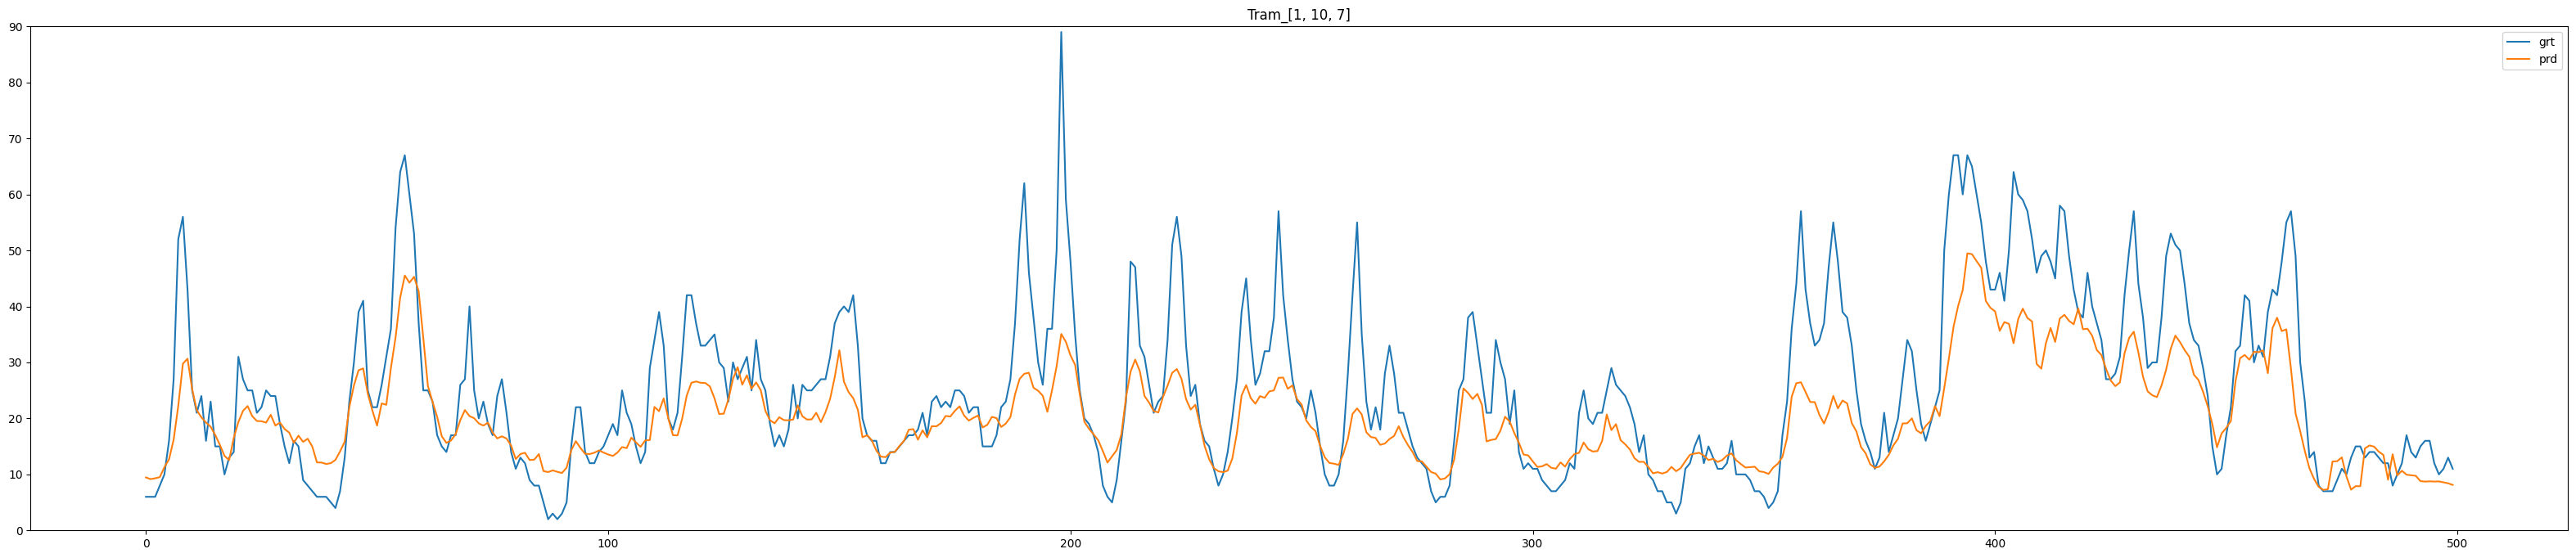

In [3]:
from utilities.functions.constructor import AQDataSet 

test_station = [1, 10, 7]
train_station = [2, 4, 5, 6, 8, 9, 11, 12, 14, 15] + [0, 3, 13]
combined_array = np.concatenate([norm_loc, norm_temp, norm_imputed], axis=2)
target_feature = ['Stickstoffdioxid']
loc_feature =['prop_intercept_200', 'prop_intercept_50', 'GVI_50', 'GVI_200', 'tvi_50', 'tvi_200', 'prop_main_', 'nearest_st', 'nearest_in', 'pop_200','pop_500'] 
temp_feature =['free_wind','weekend', 'rushhour', 'lai_factor', 'prec_mm', 'prec_bool', 'humidity',  'temp', 'radiation', 'wind_speed', 'air_pressure', 'wind_degree']
column_names = target_feature +   temp_feature + loc_feature



# define different (per site) evaluation matrices 
def cal_acc(y_prd, y_grt):
    mae = mean_absolute_error(y_grt, y_prd)
    mse = mean_squared_error(y_grt, y_prd, squared=True)
    mape = mean_absolute_percentage_error(y_grt, y_prd)
    rmse = mean_squared_error(y_grt, y_prd, squared=False)
    corr = np.corrcoef(np.reshape(y_grt, (-1)), np.reshape(y_prd, (-1)))[0][1]
    r2 = r2_score(y_grt, y_prd)
    mdape = np.median((np.abs(np.subtract(y_grt, y_prd)/ y_grt))) * 100
    
    return mae, mse, mape, rmse, r2, corr, mdape

def rescale_to_df(current_station, scaler, array, column_names):
        current_array = array.copy()
        current_array= current_array[:, current_station:current_station + 1, :].reshape(-1, current_array.shape[-1])
        array_inverse = scaler.inverse_transform(current_array)
        return pd.DataFrame(array_inverse, columns= column_names)


list_acc = []
predict = {}



feature = 0
print(column_names[(feature + 13)])

for cur_test_station in test_station:
    
    temp_shuffeled = norm_loc.copy()
    np.random.shuffle(temp_shuffeled[:, cur_test_station, feature]) 
    station_name = stations[cur_test_station]
    # embed test data in graph structure
    test_dataset = AQDataSet(
        data_df= norm_loc, # temp_shuffeled,
        climate_df= norm_temp, #,
        distance_matrix = distance_matrix,
        list_train_station= train_station,
        test_station= cur_test_station,
        test=True,
        input_dim= 12,
        corr=corr,
    )

    # structure in batches for easier and conforming data handling 
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

    # use model to predict
    mse_loss = torch.nn.MSELoss()



    list_prd, list_grt, _ = test_atten_decoder_fn(
        stdgi,
        decoder,
        test_dataloader,
        device,
        mse_loss,
        scaler,
        test= True,
    )
    
    output_arr = np.concatenate((np.array(list_grt).reshape(-1, 1), np.array(list_prd).reshape(-1, 1)), axis=1,)
    
    out_df = pd.DataFrame(output_arr, columns=["ground_truth", "prediction"])
    #df = rescale_to_df(current_station= cur_test_station, scaler= scaler , array= combined_array, column_names= column_names + ['Not_imputed'])[11:].reset_index()
    #out_df = pd.concat([out_df, df], axis= 1)
    #out_df.to_csv(f'output/performance/new_gnn_{stations[cur_test_station]}.csv') 
    
    mae, mse, mape, rmse, r2, corr_, mdape = cal_acc(list_prd, list_grt)

    list_acc.append([cur_test_station, mae, mse, mape, mdape, rmse, r2, corr_])
    predict[cur_test_station] = {"grt": list_grt, "prd": list_prd}
    print("Test Accuracy: {}".format(mae, mse, corr))

for cur_test_station in test_station:
    df = pd.DataFrame(data=predict[cur_test_station], columns=["grt", "prd"])
    
tmp = np.array(list_acc)[1:].mean(0)
list_acc.append(tmp)
df = pd.DataFrame(
    np.array(list_acc),
    columns=["STATION", "MAE", "MSE", "MAPE", "MDAPE", "RMSE", "R2", "CORR"],
)

print(df)

for cur_test_station in test_station:
    prd = predict[cur_test_station]["prd"]
    grt = predict[cur_test_station]["grt"]

    df_stat = pd.DataFrame({"Predict": prd, "Groundtruth": grt})
    x = 500
    fig, ax = plt.subplots(figsize=(40, 8))
    # ax.figure(figsize=(20,8))
    ax.plot(np.arange(x), grt[:x], label="grt")
    ax.plot(np.arange(x), prd[:x], label="prd")
    ax.legend()
    ax.set_ylim(0,90)
    ax.set_title(f"Tram_{test_station}")